<a href="https://colab.research.google.com/github/Dena-Kazerani/stock-prediction/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Import finance API and get historical stock data
!pip install yfinance
#!pip install -U scikit-learn
import yfinance as yf
import os
import json
import pandas as pd


DATA_PATH = "msft_data.json"
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

# Save file to json in case we need it later.  This prevents us from having to re-download it every time.
msft_hist.to_json(DATA_PATH)


     |████████████████████████████████| 63 kB 707 kB/s 
     |████████████████████████████████| 6.4 MB 9.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055949,0.064177,0.055949,0.061434,1031788800,0.0,0.0
1986-03-14,0.061434,0.064725,0.061434,0.063628,308160000,0.0,0.0
1986-03-17,0.063628,0.065274,0.063628,0.064725,133171200,0.0,0.0
1986-03-18,0.064725,0.065274,0.062531,0.063079,67766400,0.0,0.0
1986-03-19,0.063079,0.063628,0.061434,0.061982,47894400,0.0,0.0


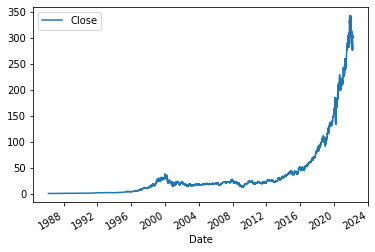

In [7]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [8]:


# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]



In [9]:


# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)



In [10]:


# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

In [11]:
import sklearn
# Random forest hyperparameter tuning using optuna

def objective(trial):
      n_estimators = trial.suggest_int('n_estimators', 2, 20)
      max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
      clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
      return sklearn.model_selection.cross_val_score(clf, train[predictors], train["Target"], 
           n_jobs=-1, cv=5).mean()


In [12]:
!pip install optuna
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-03-25 17:59:55,282] A new study created in memory with name: no-name-424a3952-4fc5-449b-a5de-b1cb90d609e5
[I 2022-03-25 17:59:57,526] Trial 0 finished with value: 0.4899229475505451 and parameters: {'n_estimators': 10, 'max_depth': 12.178977951566404}. Best is trial 0 with value: 0.4899229475505451.
[I 2022-03-25 17:59:57,957] Trial 1 finished with value: 0.4851344049039912 and parameters: {'n_estimators': 12, 'max_depth': 4.086984902543314}. Best is trial 0 with value: 0.4899229475505451.
[I 2022-03-25 17:59:58,078] Trial 2 finished with value: 0.48791954668322485 and parameters: {'n_estimators': 4, 'max_depth': 1.1104385935743402}. Best is trial 0 with value: 0.4899229475505451.
[I 2022-03-25 17:59:59,616] Trial 3 finished with value: 0.48736349744005414 and parameters: {'n_estimators': 16, 'max_depth': 22.17451279049063}. Best is trial 0 with value: 0.4899229475505451.
[I 2022-03-25 18:00:00,884] Trial 4 finished with value: 0.4899233813346421 and parameters: {'n_estimators'

In [13]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.4999442897281165
Best hyperparameters: {'n_estimators': 18, 'max_depth': 1.1434929573566621}


In [14]:
#Test the hyperparameter tuned random forest on test set 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

model=RandomForestClassifier(n_estimators = trial.params["n_estimators"], max_depth = trial.params["max_depth"], random_state = 1)
# Evaluate error of predictions
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds) 

0.49

In [15]:

from xgboost import XGBClassifier
def objective_xgb(trial):
  params={
          "n_estimators" : trial.suggest_int('n_estimators', 2, 1000),
          "max_depth": trial.suggest_int("max_depth", 1, 32),
          "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
          "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
          "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
          "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
          "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
          "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
          "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
          "n_jobs": 1,
  }
  clf = XGBClassifier(**params)
  return sklearn.model_selection.cross_val_score(clf, train[predictors], train["Target"], 
           n_jobs=-1, cv=5).mean()

In [ ]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2022-03-25 18:04:53,832] A new study created in memory with name: no-name-cd6628d6-a801-415f-9799-f894a5821e57
[I 2022-03-25 18:04:56,266] Trial 0 finished with value: 0.47945796818007735 and parameters: {'n_estimators': 169, 'max_depth': 16, 'alpha': 0.14663590564388707, 'lambda': 5.844757911392701e-06, 'learning_rate': 0.048485917973479745, 'colsample_bytree': 0.4835858336122187, 'subsample': 0.40433481437763397, 'min_child_weight': 77.61194820095598}. Best is trial 0 with value: 0.47945796818007735.
[I 2022-03-25 18:04:57,985] Trial 1 finished with value: 0.4836895940152667 and parameters: {'n_estimators': 147, 'max_depth': 14, 'alpha': 0.16772173448655125, 'lambda': 1.2724036593778063, 'learning_rate': 0.00619274235514054, 'colsample_bytree': 0.2544975913043866, 'subsample': 0.40211701196102256, 'min_child_weight': 81.06590763452735}. Best is trial 1 with value: 0.4836895940152667.
[I 2022-03-25 18:05:03,700] Trial 2 finished with value: 0.5058443731386014 and parameters: {'n_es

In [16]:
trial_xgb = study_xgb.best_trial
print('Accuracy: {}'.format(trial_xgb.value))
print("Best hyperparameters: {}".format(trial_xgb.params))

Accuracy: 0.5057893445274417
Best hyperparameters: {'n_estimators': 92, 'max_depth': 9, 'alpha': 0.013843824905852703, 'lambda': 3.2930001627625907, 'learning_rate': 0.03963616320315951, 'colsample_bytree': 0.21823073469225618, 'subsample': 0.40583408971376167, 'min_child_weight': 888.1924384667951}


In [19]:
from sklearn.metrics import precision_score
# Evaluate error of predictions
model_xgb = XGBClassifier(**trial_xgb.params)
model_xgb.fit(train[predictors], train["Target"])
preds_xgb = model_xgb.predict(test[predictors])
preds_xgb = pd.Series(preds_xgb, index=test.index)
precision_score(test["Target"], preds_xgb) 

0.49

In [4]:
!pip install optuna
import optuna
def best_trial(objective, nb_trials):
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials= nb_trials)
  trial = study.best_trial
  print('Accuracy: {}'.format(trial.value))
  print("Best hyperparameters: {}".format(trial.params))
  return trial

def precision(model):
  # Evaluate error of predictions
  model.fit(train[predictors], train["Target"])
  preds= model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index)
  print(precision_score(test["Target"], preds))


from sklearn.tree import DecisionTreeClassifier
#DecisionTreeClassifier
def objective_dtc(trial):
  max_depth = trial.suggest_int('max_depth', 5, train.shape[1])
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
  clf = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
  return sklearn.model_selection.cross_val_score(clf, train[predictors], train["Target"], 
           n_jobs=-1, cv=5).mean()


best_trial_dtc = best_trial(objective_dtc, 100)
          

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 210 kB 44.6 MB/s 
     |████████████████████████████████| 78 kB 5.6 MB/s 
     |████████████████████████████████| 113 kB 55.6 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 150 kB 54.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=51d7c4e1831cbb74e9ccffac49bf9f7a39eb920d7e0d3ca307c9b47f39659d2a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


[I 2022-03-25 17:58:56,757] A new study created in memory with name: no-name-d742906b-bcb5-42f1-b28d-12c1e8705843
[W 2022-03-25 17:58:56,761] Trial 0 failed because of the following error: NameError("name 'train' is not defined")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-4-1df2282d3daa>", line 22, in objective_dtc
    max_depth = trial.suggest_int('max_depth', 5, train.shape[1])
NameError: name 'train' is not defined


NameError: ignored

In [24]:


# Evaluate error of predictions
precision(DecisionTreeClassifier(**best_trial_dtc.params))

0.4857142857142857


In [1]:
from sklearn.ensemble import GradientBoostingClassifier
#gradient boosting classifier

def objective_gbc(trial):
  params = {
      "n_estimators": optuna.distributions.IntUniformDistribution(50, 100),
      "max_depth": optuna.distributions.IntLogUniformDistribution(2, 7),
      "learning_rate": optuna.distributions.UniformDistribution(0, 1)
  }
  clf = GradientBoostingClassifier(**params)
  return sklearn.model_selection.cross_val_score(clf, train[predictors], train["Target"], 
           n_jobs=-1, cv=5).mean()


best_trial_gbc = best_trial(objective_gbc, 100)

# Evaluate error of predictions
precision(GradientBoostingClassifier(best_trial_gbc.params))

NameError: ignored

In [ ]:
import keras.layers as kl
from keras.models import Model
from keras import regularizers
#define the LSTM neural network
input_data = kl.Input(shape=(1,train.shape[1]))
lstm = kl.LSTM(5, input_shape=(1,train.shape[1]), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)
lstmNN=Model(input_data, out)
lstmNN._estimator_type = "classifier"

In [ ]:

from xgboost import XGBClassifier
#define base models
level0 = []
level0.append(('rf', RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)))
level0.append(('lstm', lstmNN))
level0.append(('xgbc', XGBClassifier()))

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(train[predictors], train["Target"])

TypeError: ignored

In [ ]:


from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)



0.5

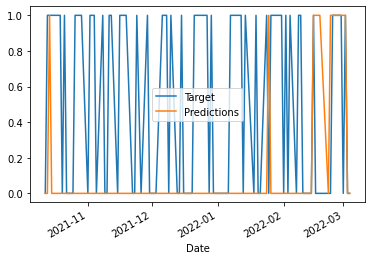

In [ ]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()